In [133]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

features=["Plasma","BMI","AGE","PEDIGREE","BP","NOP","SERUM_INSULIN","TSKIN_THICKNESS","Target"]
attributesToClean = ["Plasma","BMI","BP"]

def load_data(path):
    diabetes = pd.read_csv(path,header=0)
    return diabetes

def load_diabetes_data():
    PATH = "datasets/Diabetes/pima-indians-diabetes.csv"
    diabetes_df = load_data(PATH)
    feature_names = diabetes_df.columns.array.copy()
    return diabetes_df,feature_names
    
def Separate_X_y_data(data):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    data = data.iloc[shuffled_indices]
    y = data[["Target"]]
    X = data.drop(columns='Target')
    return X,y

# This returns X_train, X_test, y_train, y_test
def produce_train_test_data(data,test_ratio):
    test_set_size = int(len(data)*test_ratio)
    return data[test_set_size:], data[:test_set_size]

class RemoveInvalidZeroValuesAttributes(BaseEstimator, TransformerMixin):
    def __init__(self,attributes):
        self.attributes = attributes
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        attrs = self.attributes
        for attribute in attrs:
            X= X[X[attribute]>0]
        return X

class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,features):
        self.features = features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        features = self.features
        X = X[features]
        return X

def preprocess_data(X,features,attributes):
    data_preprocess_pipeline = Pipeline([("feature_selection",FeatureSelection(features)),("clean_zero",RemoveInvalidZeroValuesAttributes(attributes)),])
    #data_preprocess_pipeline = Pipeline([("clean_zero",RemoveInvalidZeroValuesAttributes(attributes)),])
    X = data_preprocess_pipeline.fit_transform(X)
    return X

def scaleAndPreprocessData(data,features,attributes):
    data = preprocess_data(data,features,attributes)
    X,y = Separate_X_y_data(data)
    col = X.columns.array.copy()
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
    X = pd.DataFrame(data=X,columns=col)
    return X, y
    
# trying chapter 7 concepts

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

def getPerformances(X_train, X_test, y_train, y_test):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier()
    log_clf = LogisticRegression()
    svm_clf = SVC()
    tree_clf = DecisionTreeClassifier()
    KNN_clf = KNeighborsClassifier()
    gradient_clf = GradientBoostingClassifier()
    voting_clf = VotingClassifier(
        estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf),('tree',tree_clf),('KNN',KNN_clf),('gradient',gradient_clf)],voting = 'hard')
    voting_clf.fit(X_train,y_train)
    bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=100,max_samples=1.0,bootstrap=True,n_jobs=-1)
    pasting_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=1.0,bootstrap=False,n_jobs=-1,bootstrap_features=True,max_features=1.0)
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=15, algorithm="SAMME.R", learning_rate=0.5)
    for clf in (log_clf,rnd_clf,svm_clf,voting_clf,tree_clf,KNN_clf,gradient_clf,bag_clf,pasting_clf,ada_clf):
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        clf_name.append(clf.__class__.__name__)
        score = accuracy_score(y_test,y_pred)
        clf_performance.append(score)
        print(clf.__class__.__name__,accuracy_score(y_test,y_pred))
    return clf_name,clf_performance
        
def getScoreTrainTest(X_train, X_test, y_train, y_test,clf):
    clf.fit(X_train,y_train)
    y_tarin_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    training_score = accuracy_score(y_train,y_tarin_pred)
    testing_score = accuracy_score(y_test,y_test_pred)
    return training_score,testing_score

def getPerformanceCV(X_train, y_train,scoring):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier()
    log_clf = LogisticRegression()
    svm_clf = SVC()
    tree_clf = DecisionTreeClassifier()
    KNN_clf = KNeighborsClassifier()
    gradient_clf = GradientBoostingClassifier()
    bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=100,max_samples=1.0,bootstrap=True,n_jobs=-1)
    pasting_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=1.0,bootstrap=False,n_jobs=-1,bootstrap_features=True,max_features=1.0)
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=15, algorithm="SAMME.R", learning_rate=0.5)
    score_df = pd.DataFrame(columns=["classifier","mean","min","max","deviation"])
    count = 0
    for clf in (log_clf,rnd_clf,svm_clf,tree_clf,KNN_clf,gradient_clf,bag_clf,pasting_clf,ada_clf):
        score = cross_val_score(clf,X_train,y_train,cv=4,scoring=scoring)
        mean = score.mean()
        deviation = score.std() * 2
        maximum = mean+deviation
        minimum = mean-deviation
        score_df.loc[count] = [clf.__class__.__name__,mean,minimum,maximum,deviation]
        count = count+1
    return score_df
    
# TODO : Need to look into how to calculate AUC for voting classifier
def getAUCScore(X_train, y_train):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier()
    log_clf = LogisticRegression()
    svm_clf = SVC(random_state=42)
    tree_clf = DecisionTreeClassifier()
    KNN_clf = KNeighborsClassifier()
    gradient_clf = GradientBoostingClassifier()
    bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=100,max_samples=0.40,bootstrap=True,n_jobs=-1)
    pasting_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=0.40,bootstrap=False,n_jobs=-1,bootstrap_features=True,max_features=1.0)
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=15, algorithm="SAMME.R", learning_rate=0.5)
    score_df = pd.DataFrame(columns=["classifier","score"])
    count = 0
    for clf in (log_clf,rnd_clf,svm_clf,tree_clf,KNN_clf,gradient_clf,bag_clf,pasting_clf,ada_clf):
        name = clf.__class__.__name__
        if name in ['SVC','Logistic Regression']:
            y_scores = cross_val_predict(clf,X_train,y_train,cv=3, method="decision_function")
            score = roc_auc_score(y_train, y_scores)
        elif name in ['VotingClassifier']:
            score = cross_val_score(clf,X_train,y_train,cv=4,scoring="accuracy").mean()
        else:
            print(name)
            y_scores = cross_val_predict(clf,X_train,y_train,cv=3, method = "predict_proba")
            y_scores = y_scores[:,1]
            score = roc_auc_score(y_train, y_scores)
        clf_name.append(name)
        clf_performance.append(score)
        print(name,score)
        score_df.loc[count] = [name,score]
        count =count+1
    return score_df

def getAUC_ROC_score(X_train, y_train,clf,method):
    if method in (['decision_function','accuracy']):
        y_scores = cross_val_predict(clf,X_train,y_train,cv=3, method="decision_function")
        score = roc_auc_score(y_train, y_scores)
    if method in ('predict_proba'):
        y_scores = cross_val_predict(clf,X_train,y_train,cv=3, method = "predict_proba")
        y_scores = y_scores[:,1]
        score = roc_auc_score(y_train, y_scores)
    return score

In [82]:
diabetes_df,feature_names = load_diabetes_data()

In [83]:
train,test = produce_train_test_data(diabetes_df,0.1)

In [84]:
# keep aside test data and train model on training data.
train_data_cleaned = preprocess_data(train,features,attributesToClean)


In [85]:
# scaling on train data
X_train,y_train = Separate_X_y_data(train_data_cleaned)
scale = StandardScaler()
scale.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [86]:
scale.mean_,scale.var_,scale.scale_

(array([121.60091743,  32.47996942,  33.06727829,   0.46812538,
         72.33486239,   3.77828746,  84.08562691,  21.5030581 ]),
 array([9.26215351e+02, 4.73477486e+01, 1.38845627e+02, 1.03763342e-01,
        1.49626399e+02, 1.10991616e+01, 1.29885768e+04, 2.45256107e+02]),
 array([ 30.43378634,   6.88097004,  11.78327741,   0.32212318,
         12.23218702,   3.33154042, 113.96743731,  15.66065474]))

In [87]:
# will use same scaler for tranforming test data.
X_train_scaled = scale.transform(X_train)

c:\python27\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [88]:
# now try models using cross validation with and without scaling

In [89]:
# Logistic has mean 76.45 with +/- .029 deviation 2sigma, for 95% confidence interval

In [90]:
# top rankers;1. Bagging,Random forest, Gradient,Logistic, Adaboost


In [97]:
#withh scaling
score_df = getPerformanceCV(X_train_scaled,y_train,"accuracy")


('classifier', 'LogisticRegression', 0.7782859078590785, 0.05198181493656188, 'Range:', 0.8302677227956403, ':', 0.7263040929225166)
('classifier', 'RandomForestClassifier', 0.7721130683529058, 0.022527123854489926, 'Range:', 0.7946401922073958, ':', 0.7495859444984159)
('classifier', 'SVC', 0.7721130683529058, 0.04864651890648993, 'Range:', 0.8207595872593958, ':', 0.7234665494464159)
('classifier', 'VotingClassifier', 0.7676339957844023, 0.03635467891499828, 'Range:', 0.8039886746994006, ':', 0.731279316869404)
('classifier', 'DecisionTreeClassifier', 0.7110245408009636, 0.036367302757740305, 'Range:', 0.7473918435587039, ':', 0.6746572380432232)
('classifier', 'KNeighborsClassifier', 0.7507716049382716, 0.04488739224034129, 'Range:', 0.7956589971786129, ':', 0.7058842126979302)
('classifier', 'GradientBoostingClassifier', 0.7737127371273713, 0.04365583656798652, 'Range:', 0.8173685736953579, ':', 0.7300569005593848)
('classifier', 'BaggingClassifier', 0.7874322493224932, 0.017256484

In [98]:
score_df.sort_values(ascending=False,by="mean")

,classifier,mean,min,max,deviation
7,BaggingClassifier,0.787432,0.770176,0.804689,0.017256
0,LogisticRegression,0.778286,0.726304,0.830268,0.051982
6,GradientBoostingClassifier,0.773713,0.730057,0.817369,0.043656
1,RandomForestClassifier,0.772113,0.749586,0.794640,0.022527
2,SVC,0.772113,0.723467,0.820760,0.048647
3,VotingClassifier,0.767634,0.731279,0.803989,0.036355
5,KNeighborsClassifier,0.750772,0.705884,0.795659,0.044887
9,AdaBoostClassifier,0.746067,0.703108,0.789025,0.042959
8,BaggingClassifier,0.744693,0.717236,0.772149,0.027456
4,DecisionTreeClassifier,0.711025,0.674657,0.747392,0.036367


In [99]:
scoredf=getAUCScore(X_train=X_train_scaled,y_train=y_train)

LogisticRegression
('LogisticRegression', 0.8438356164383563)
RandomForestClassifier
('RandomForestClassifier', 0.7900120715897759)
('SVC', 0.8268724085445862)
('VotingClassifier', 0.7782859078590786)
DecisionTreeClassifier
('DecisionTreeClassifier', 0.6510470792001259)
KNeighborsClassifier
('KNeighborsClassifier', 0.7737101768750329)
GradientBoostingClassifier
('GradientBoostingClassifier', 0.8152416942213825)
BaggingClassifier
('BaggingClassifier', 0.8257124862226422)
BaggingClassifier
('BaggingClassifier', 0.8284837033538026)
AdaBoostClassifier
('AdaBoostClassifier', 0.7442030126489266)


In [100]:
scoredf.sort_values(by="score",ascending=False)

,classifier,score
0,LogisticRegression,0.843836
8,BaggingClassifier,0.828484
2,SVC,0.826872
7,BaggingClassifier,0.825712
6,GradientBoostingClassifier,0.815242
1,RandomForestClassifier,0.790012
3,VotingClassifier,0.778286
5,KNeighborsClassifier,0.773710
9,AdaBoostClassifier,0.744203
4,DecisionTreeClassifier,0.651047


In [17]:
# Now top rankers are LogisticRegression,RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier

In [20]:
# Overall performance rankers, LogisticRegression,SVC,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier

### analyze train test errors in cross validation.LogisticRegression,SVC,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier have higher accuracy as well as higher AUC score for overall performance. so picking these to fine tune.

In [101]:
from sklearn.model_selection import cross_validate

In [105]:
svm_clf = SVC(random_state=42)
scores = cross_validate(estimator=svm_clf,X=X_train_scaled,y=y_train,scoring="accuracy",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.764525993883792, 0.8417431192660549)

In [104]:
scores

{'fit_time': array([0.0079999 , 0.00800014, 0.00299978]),
 'score_time': array([0.00200009, 0.00199986, 0.        ]),
 'test_score': array([0.81192661, 0.74770642, 0.73394495]),
 'train_score': array([0.8440367 , 0.85091743, 0.83027523])}

In [225]:

def validateModels(X_train, y_train,scoring):
    rnd_clf = RandomForestClassifier()
    log_clf = LogisticRegression()
    svm_clf = SVC(random_state=42)
    gradient_clf = GradientBoostingClassifier()
    bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=100,max_samples=0.40,bootstrap=True,n_jobs=-1)
    score_df = pd.DataFrame(columns=["classifier","train_score","test_score"])
    count = 0
    for clf in (log_clf,rnd_clf,svm_clf,gradient_clf,bag_clf):
        name = clf.__class__.__name__
        scores = cross_validate(estimator=clf,X=X_train,y=y_train,scoring=scoring,cv=3,n_jobs=-1,return_train_score=True)
        test_score=scores["test_score"].mean() 
        train_score=scores["train_score"].mean()
        score_df.loc[count] = [name,train_score,test_score]
        count =count+1
    return score_df

In [226]:
scores_df=validateModels(X_train_scaled,y_train,"accuracy")

In [227]:
scores_df

,classifier,train_score,test_score
0,LogisticRegression,0.785933,0.788991
1,RandomForestClassifier,0.982416,0.740061
2,SVC,0.841743,0.764526
3,GradientBoostingClassifier,0.961774,0.756881
4,BaggingClassifier,0.927370,0.772171


### Except logistic all are overfitting. Random forest is most overfitting. SVC also less overfitting than otherson accuracy.

In [228]:
scores_df=validateModels(X_train_scaled,y_train,"roc_auc")

In [229]:
scores_df

,classifier,train_score,test_score
0,LogisticRegression,0.854889,0.844151
1,RandomForestClassifier,0.999543,0.789860
2,SVC,0.913801,0.830389
3,GradientBoostingClassifier,0.994607,0.817761
4,BaggingClassifier,0.985317,0.816863


### For AUC score, Logistic is least overfitting, random forest and Gradient are so overfitting that training score is almost 100% but not doing great on test score. Again SVC is moderatively overfitting.

In [123]:
# Lets fine tune the above ones
from sklearn.model_selection import GridSearchCV
param_grid_val = ({'C' : [1.0,0.9,0.8],'warm_start' : [True,False]})
logistic_clf = LogisticRegression(random_state=42)
grid_logistic = GridSearchCV(cv=4,estimator=logistic_clf,param_grid=param_grid_val)
grid_logistic.fit(X_train_scaled,y_train)
grid_logistic.best_params_

{'C': 1.0, 'warm_start': True}

In [140]:
grid_logistic.best_params_


{'C': 1.0, 'warm_start': True}

In [141]:
logistic_clf = LogisticRegression(warm_start=True)

In [142]:
score_AUC = getAUC_ROC_score(X_train_scaled,y_train,logistic_clf,'accuracy')

In [143]:
score_AUC

0.8438356164383563

In [146]:
scores = cross_validate(estimator=logistic_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8441505274759881, 0.8548889938592348)

In [148]:
logistic_clf = LogisticRegression()
scores = cross_validate(estimator=logistic_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8441505274759881, 0.8548889938592348)

### Seems like default logistic is best model. There was nothing much to fine tune logistic, now do this for SVC

In [155]:
#There was nothing much to fine tune logistic, now do this for SVC
param_grid_val = ({'gamma':[0.1,0.2,0.3,0.4],'kernel':['poly', 'rbf', 'sigmoid']},
                  {'kernel':['linear']})
clf_svc = SVC()
grid_SVC = GridSearchCV(cv=4,estimator=clf_svc,param_grid=param_grid_val,scoring="roc_auc")

In [156]:
grid_SVC.fit(X_train_scaled,y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=({'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': [0.1, 0.2, 0.3, 0.4]}, {'kernel': ['linear']}),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [157]:
grid_SVC.best_params_

{'kernel': 'linear'}

In [158]:
grid_SVC.best_score_

0.8442074420948252

In [161]:
clf_svc = SVC(kernel='linear',random_state=42)
scores = cross_validate(estimator=clf_svc,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8479294599275704, 0.8528184537868052)

In [162]:
clf_svc = SVC(random_state=42)
scores = cross_validate(estimator=clf_svc,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8303889151314753, 0.9138009762242166)

### Doing grid search for roc_auc scoring, SVM gives kernel=linear the best param. Using it increases test score from 83 to 84 and decreases training score from 91 to 85. Hence for linear it is more generalized.

In [168]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf=RandomForestClassifier()
param_grid_val={'n_estimators':[5,10,20,30,40],'max_leaf_nodes':[12,14,16,18]}
gris_rnd = GridSearchCV(cv=3,estimator=rnd_clf,param_grid=param_grid_val,scoring="roc_auc")
gris_rnd.fit(X_train_scaled,y_train)

#rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 20, 30, 40], 'max_leaf_nodes': [12, 14, 16, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [169]:
gris_rnd.best_params_

{'max_leaf_nodes': 14, 'n_estimators': 30}

In [174]:
#using best parameters for random forest.
rnd_clf = RandomForestClassifier(n_estimators=30,max_leaf_nodes=14,n_jobs=-1)
scores = cross_validate(estimator=rnd_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8320894347346875, 0.9378523067233507)

In [175]:
rnd_clf = RandomForestClassifier()
scores = cross_validate(estimator=rnd_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8030231459612659, 0.9989293024720517)

### After using best parameter it is more generalized as test score goes up from 80 to 83 and training data is not overfitted as it goes down from 99 percent to 93 percent.

### fine tune gradient boosting

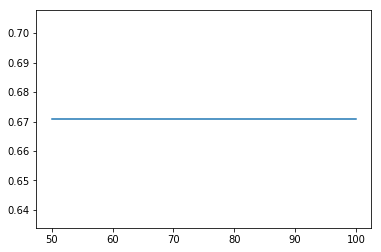

In [182]:
# check best number of estimator
estomator_number=[]
scoreBag = []
for n_estimator in [50,60,70,80,90,100]:
    gradient_clf = GradientBoostingClassifier(max_depth=100,n_estimators=n_estimator,learning_rate=1.0,random_state=42)
    gradient_clf.fit(X_train_scaled,y_train)
    y_pred = gradient_clf.predict(X_test)
    score = roc_auc_score(y_test,y_pred)
    estomator_number.append(n_estimator)
    scoreBag.append(score)

plt.plot(estomator_number,scoreBag)

### why this is a straight line?

In [191]:
gradient_clf = GradientBoostingClassifier(random_state=42)
param_grid_val={'n_estimators':[50,60,70,80,90,100],'max_depth':[1,2,3,4,5,6,7,10,20,30,40,50,60,70]}
gris_rnd = GridSearchCV(cv=3,estimator=gradient_clf,param_grid=param_grid_val,scoring="roc_auc")
gris_rnd.fit(X_train_scaled,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70, 80, 90, 100], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 10, 20, 30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [192]:
gris_rnd.best_params_

{'max_depth': 1, 'n_estimators': 100}

In [197]:
gradient_clf = GradientBoostingClassifier(random_state=42,max_depth=1,n_estimators=100)
scores = cross_validate(estimator=gradient_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8373169579593766, 0.8970634545740829)

In [198]:
gradient_clf = GradientBoostingClassifier(random_state=42)
scores = cross_validate(estimator=gradient_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8184222957014643, 0.9946071484805543)

### Best parameter of {'max_depth': 1, 'n_estimators': 100} increased score percentage from 81 to 83 and decreased training score from 99 to 89. Hence, with best parameters it is more generalized.

### Fine tune last model bagging

In [209]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),bootstrap=False,n_jobs=-1
)
param_grid_val={'n_estimators':[400,410,420],'max_samples':[40,50,60,70]}
gris_rnd = GridSearchCV(cv=3,estimator=bag_clf,param_grid=param_grid_val,scoring="roc_auc")
gris_rnd.fit(X_train_scaled,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ..._estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [400, 410, 420], 'max_samples': [40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [210]:
gris_rnd.best_params_

{'max_samples': 60, 'n_estimators': 420}

In [217]:
#using best paramters
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),bootstrap=False,n_jobs=-1,n_estimators=420,max_samples=60
)
scores = cross_validate(estimator=bag_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.8305306250984096, 0.9221658006613133)

In [219]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),bootstrap=False,n_jobs=-1
)
scores = cross_validate(estimator=bag_clf,X=X_train_scaled,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
test_score=scores["test_score"].mean() 
train_score=scores["train_score"].mean() 
test_score,train_score

(0.6668083766336009, 1.0)

### Best parameter improved expremely fit model of training score 1 with test score 67% to 83 test score and 92 training score.

In [42]:
# list of fine tuned models
#logistic- default
#SVC - default
#Bagging - 
# Ada- ada_clf = DecisionTreeClassifier(max_depth=3),n_estimators=14, algorithm="SAMME.R", learning_rate=0.5
# RandomForest - rnd_clf = RandomForestClassifier(n_estimators=30,max_leaf_nodes=16,n_jobs=-1)
# Gradient - gradient_clf = GradientBoostingClassifier(max_depth=60,n_estimators=80,learning_rate=1.0)

### Test all models with their best parameters

In [231]:
# Running all once again

def getPerformanceCVSelected(X_train, y_train):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier(n_estimators=30,max_leaf_nodes=14,n_jobs=-1)
    log_clf = LogisticRegression()
    svm_clf = SVC(kernel='linear',random_state=42)
    gradient_clf = GradientBoostingClassifier(random_state=42,max_depth=1,n_estimators=100)
    bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=420,max_samples=60,bootstrap=True,n_jobs=-1)
    score_df = pd.DataFrame(columns=["classifier","train_score","test_score"])
    count=0
    for clf in (log_clf,rnd_clf,svm_clf,gradient_clf,bag_clf):
        scores = cross_validate(estimator=clf,X=X_train,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
        test_score=scores["test_score"].mean() 
        train_score=scores["train_score"].mean() 
        score_df.loc[count] = [clf.__class__.__name__,train_score,test_score]
        count= count+1
    return score_df

In [232]:
score_df = getPerformanceCVSelected(X_train_scaled,y_train)

In [234]:
score_df.sort_values(by="test_score",ascending=False)

,classifier,train_score,test_score
2,SVC,0.852818,0.847929
0,LogisticRegression,0.854889,0.844151
3,GradientBoostingClassifier,0.897063,0.837317
1,RandomForestClassifier,0.937545,0.832845
4,BaggingClassifier,0.919647,0.828263


### As per above table, SVC and Logistic are least overfitting. Lets check deviation of test score.

In [242]:
def getPerformanceRangeCVSelected(X_train, y_train):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier(n_estimators=30,max_leaf_nodes=14,n_jobs=-1)
    log_clf = LogisticRegression()
    svm_clf = SVC(kernel='linear',random_state=42)
    gradient_clf = GradientBoostingClassifier(random_state=42,max_depth=1,n_estimators=100)
    bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=420,max_samples=60,bootstrap=True,n_jobs=-1)
    score_df = pd.DataFrame(columns=["classifier","train_score","test_score","overfitting","test_min","test_max","deviation"])
    count=0
    for clf in (log_clf,rnd_clf,svm_clf,gradient_clf,bag_clf):
        scores = cross_validate(estimator=clf,X=X_train,y=y_train,scoring="roc_auc",cv=3,n_jobs=-1,return_train_score=True)
        test_score=scores["test_score"].mean() 
        train_score=scores["train_score"].mean() 
        deviation = scores["test_score"].std() * 2
        maximum = test_score+deviation
        minimum = test_score-deviation
        overfitting=train_score-test_score
        score_df.loc[count] = [clf.__class__.__name__,train_score,test_score,overfitting,minimum,maximum,deviation]
        count= count+1
    return score_df

In [243]:
score_df = getPerformanceRangeCVSelected(X_train=X_train_scaled,y_train=y_train)


In [245]:
score_df.sort_values(by="test_score",ascending=False)

,classifier,train_score,test_score,overfitting,test_min,test_max,deviation
2,SVC,0.852818,0.847929,0.004889,0.807052,0.888807,0.040878
0,LogisticRegression,0.854889,0.844151,0.010738,0.814286,0.874015,0.029865
3,GradientBoostingClassifier,0.897063,0.837317,0.059746,0.786058,0.888576,0.051259
1,RandomForestClassifier,0.938183,0.827586,0.110597,0.801739,0.853433,0.025847
4,BaggingClassifier,0.917493,0.823067,0.094426,0.782861,0.863274,0.040207


### SVC is top performer as it has highest test score, least overfitting model but has second highest deviation. 
### Logistic has second lowest overfitting, second highest test score and reasonable low deviation.

In [247]:
# lets test them finally on our actual test data , i would pick logistic
test_data_cleaned = preprocess_data(test,features,attributesToClean)
X_test,y_test = Separate_X_y_data(test_data_cleaned)
X_test = scale.transform(X_test) # transform with same scaler which was used in training data

c:\python27\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [253]:
def getPerformancesSelectedTesting(X_train, X_test, y_train, y_test):
    clf_name = []
    clf_performance = []
    rnd_clf = RandomForestClassifier(n_estimators=30,max_leaf_nodes=14,n_jobs=-1)
    log_clf = LogisticRegression()
    svm_clf = SVC(kernel='linear',random_state=42)
    gradient_clf = GradientBoostingClassifier(random_state=42,max_depth=1,n_estimators=100)
    bag_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=420,max_samples=60,bootstrap=True,n_jobs=-1)
    score_df = pd.DataFrame(columns=["classifier","score"])
    count = 0
    for clf in (log_clf,rnd_clf,svm_clf,gradient_clf,bag_clf):
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        auc_score_val=roc_auc_score(y_test,y_pred)
        score_df.loc[count] = [clf.__class__.__name__,auc_score_val]
        count= count+1
    return score_df

In [254]:
score_df = getPerformancesSelectedTesting(X_train=X_train_scaled,y_train=y_train,X_test=X_test,y_test=y_test)

c:\python27\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


In [256]:
score_df.sort_values(by="score",ascending=False)

,classifier,score
4,BaggingClassifier,0.712500
1,RandomForestClassifier,0.708333
2,SVC,0.700000
0,LogisticRegression,0.687500
3,GradientBoostingClassifier,0.683333


### Bagging is performation best. second best are SVC and random forest. I would pick SVC model as moderate performance on training and test.

### ### On test data, without removing data with 0 values

In [257]:
# without removing zero fromtest set
X_test,y_test = Separate_X_y_data(test)
X_test = scale.transform(X_test)

c:\python27\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [258]:
score_df = getPerformancesSelectedTesting(X_train=X_train_scaled,y_train=y_train,X_test=X_test,y_test=y_test)
score_df.sort_values(by="score",ascending=False)

c:\python27\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


,classifier,score
4,BaggingClassifier,0.536932
0,LogisticRegression,0.522727
2,SVC,0.522727
1,RandomForestClassifier,0.492898
3,GradientBoostingClassifier,0.478693


In [48]:
# it is a tie in Logistic,SVC,Bagging and winner is Random forest